### Plot Gravitino results using the DataFrame stored in GravitinoResults.pcl 

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('GravitinoResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [3]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.

In [4]:
def getShortTxname(txList):
    if not isinstance(txList,list):
        return 'None'
    if len(txList) < 1:
        return 'None'
    if 'HSCP' in txList[0]:        
        return 'MultiHSCP'    
    elif len(txList) == 1:        
        return txList[0]
    else:
        return 'MultiMET'
#Add short Txname notation:
dataDF['txshort'] = dataDF['ExptRes.result0.TxNames'].map(getShortTxname)

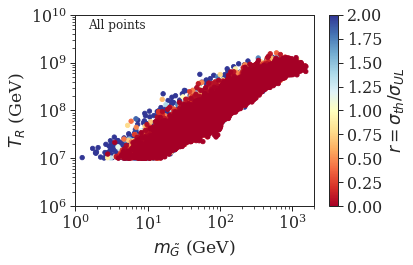

In [5]:
plt.figure()
mG = dataDF['mG']
TR = dataDF['TR']
r = dataDF['ExptRes.result0.r']
x,y,z = mG,TR,r
cp = plt.scatter(x,y, c=z, vmin=0., vmax=2., s=20, cmap=cm)
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
cb.set_label(r'$r=\sigma_{th}/\sigma_{UL}$')
plt.ylim(1e6,1e10)
plt.xlim(1e0,2e3)
plt.tight_layout()
plt.text(1.5,5e9, 'All points', fontsize=12)
plt.savefig('Gravitino_all_r.png',dpi=500)
plt.show()

excluded= 5252
non-excluded= 21316


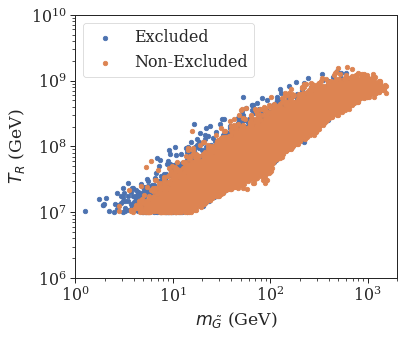

In [6]:
plt.figure(figsize=(6,5))
allowedDF = dataDF[dataDF['excluded'] == False]
excludedDF = dataDF[dataDF['excluded'] == True]
mG = excludedDF['mG']
TR = excludedDF['TR']
x,y = mG,TR
cp = plt.scatter(x,y, s=20, label='Excluded')
mG = allowedDF['mG']
TR = allowedDF['TR']
x,y = mG,TR
cp = plt.scatter(x,y,s=20, label='Non-Excluded')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$m_{\tilde{G}}$ (GeV)')    
plt.ylabel(r'$T_{R}$ (GeV)')
plt.ylim(1e6,1e10)
plt.xlim(1e0,2e3)
plt.legend()
plt.tight_layout()
plt.savefig('Gravitino_all.png',dpi=500)
print('excluded=',excludedDF.shape[0])
print('non-excluded=',allowedDF.shape[0])
plt.show()

In [7]:
#Create dictionary with txname dataframes
groupedDF = OrderedDict([[tx,excludedDF[excludedDF['txshort'] == tx]] 
                         for tx in sorted(excludedDF['txshort'].unique())])

In [8]:
indexULexc = []
for index,pt in excludedDF.iterrows():
    excluedByUL = False
    if not "CMS-PAS-EXO-16-036" in pt.values:
        continue
    if not "CMS-EXO-12-026" in pt.values:
        continue
    ihscp = np.where((pt.values == "CMS-EXO-12-026") | (pt.values == "CMS-PAS-EXO-16-036"))[0]
    for ires in ihscp:
        resName = pt.index[ires]
        resName = resName[:resName.rfind('.')]
        if pt[resName+'.dataType'] == 'upperLimit' and pt[resName+'.r'] > 1.:
            indexULexc.append(index)
indexULexc = list(set(indexULexc))         
excULDF = excludedDF.loc[indexULexc]
print('Excluded by UL only = ',excULDF.shape[0])

Excluded by UL only =  210


In [9]:
#Define topology dictionary
txDict = {'MultiHSCP' : 'HSCP', 
          'THSCPM1b' : r'$p p \to X_{HSCP} + X_{HSCP}$',
         'THSCPM3' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM$',
         'THSCPM5' : r'$p p \to Z + Z,\; Z \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM7' : r'$p p \to Z_1 + Z_2,\; Z_1 \to X_{HSCP} + SM,\; Z_2 \to Y + SM,\; Y \to X_{HSCP} + SM$',
         'THSCPM8' : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM + SM$',
         'TRHadGM1' : r'$R_{hadron}(\tilde{g})$',
         'TRHadQM1' : r'$R_{hadron}(\tilde{q})$',
         'Allowed' : 'Non-Excluded'
         }
#Check for undefined topologies:
for tx in groupedDF:
    if not tx in txDict:
        print(tx,'missing')

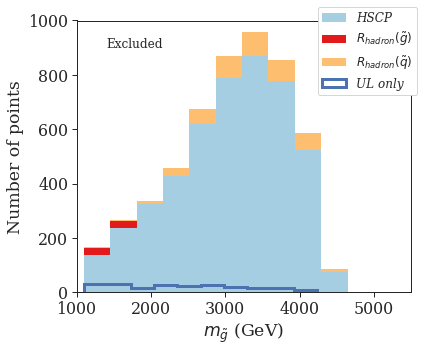

In [10]:
plt.figure(figsize=(6,5))
xvals = [gDF['mass.1000021'] for gDF in groupedDF.values()]
nbins = 10
colors = np.take(sns.color_palette("Paired"),[0,5,6],axis=0)
plt.hist(xvals,nbins,stacked=True, 
                            histtype='bar', label=[txDict[tx] for tx in groupedDF],
                            linewidth=0, color=colors,fill=True)
plt.hist(excULDF['mass.1000021'],nbins, label='UL only',linewidth=3,histtype='step')
lgd = plt.legend(bbox_to_anchor=(0.72, 1.05), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size' : 12},framealpha=1.)

plt.xlim(1000.,5500.)
plt.ylim(0.,1000.)
# plt.tight_layout()
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.ylabel('Number of points')
plt.text(1400,900, 'Excluded', fontsize=12)
plt.savefig('Gravitino_txnames.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

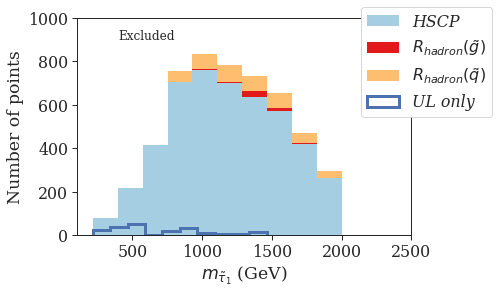

In [11]:
plt.figure()
xvals = [gDF['mass.1000015'] for gDF in groupedDF.values()]
plt.hist(xvals,nbins,stacked=True, 
                            histtype='bar', label=[txDict[tx] for tx in groupedDF],
                            linewidth=0, color=colors)
plt.hist(excULDF['mass.1000015'],nbins, label='UL only',linewidth=3,histtype='step')
lgd = plt.legend(fontsize=10,bbox_to_anchor=(0.85, 1.05), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic'},framealpha=1.)

plt.xlim(100.,2500.)
plt.ylim(0.,1000.)
# plt.tight_layout()
plt.xlabel(r'$m_{\tilde{\tau}_1}$ (GeV)')
plt.ylabel('Number of points')
plt.text(400,900, 'Excluded', fontsize=12)
plt.savefig('Gravitino_txnames_mstau.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
# plt.figure()
# groupedDF.update({'Allowed' : allowedDF})
# xvals = [gDF['mass.1000021'] for gDF in groupedDF.values()]
# colors = np.take(sns.color_palette("Paired"),[0,5,6],axis=0)
# colors = np.append(colors,[(0.8,0.8,0.8)],axis=0)
# plt.hist(xvals,nbins,stacked=True, 
#                             histtype='bar', label=[txDict[tx] for tx in groupedDF],
#                             linewidth=0, color=colors)
# plt.hist(excULDF['mass.1000021'],nbins, label='UL only',linewidth=3,histtype='step')
# lgd = plt.legend(fontsize=10,bbox_to_anchor=(0.85, 1.05), loc=2, borderaxespad=0.,
#                  prop={'family' :'serif','style' : 'italic'},framealpha=1.)

# plt.xlim(1000.,5000.)
# plt.ylim(0.,5000.)
# plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
# plt.ylabel('Number of points')
# plt.text(1500,4000, 'All points', fontsize=12)
# plt.savefig('Gravitino_txnames_nonexcluded.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
# plt.show()

In [12]:
print(excludedDF.shape)
print(allowedDF.shape)

(5252, 1087)
(21316, 1087)


In [13]:
import re
#Define topologies (particles are replaced by -> x)
f = lambda x: re.sub('[0-9a-zA-Z]+','x',x[:x.find('(')])+x[x.find('('):] if isinstance(x,str) else x
allowedDF['Missed Topologies.MT0.topo'] = allowedDF['Missed Topologies.MT0.element'].map(f)

In [14]:
#Create dictionary with txname dataframes
largeXsecsDF = allowedDF[(allowedDF['totalxsec13TeV(fb)'] > 5.) & 
                         (~pd.isnull(allowedDF['Missed Topologies.MT0.topo']))]

In [15]:
mostOccurringTopos = largeXsecsDF['Missed Topologies.MT0.topo'].value_counts()

In [19]:
missToposDict = {"[[[x,x,x]],[[x,x,x]]](HSCP,HSCP)" : r'$p p \to Y + Y,\; Y \to X_{HSCP} + SM + SM + SM$',
       "[[[x,x],[x,x]],[[x,x],[x,x]]](HSCP,HSCP)" : r'$p p \to Z + Z,\; Z \to Y + SM + SM$' +'\n\t\t'+r'$\;Y \to X_{HSCP} + SM +SM$',
       "[[[x,x],[x]],[[x,x],[x]]](HSCP,HSCP)" : r'$p p \to Z + Z,\; Z \to Y + SM + SM,$' +'\n\t\t'+r'$\;Y \to X_{HSCP} + SM$',
       "[[[x]],[[x]]](RHadronG,RHadronG)" : r'$p p \to Y + Y,\; Y \to R_{hadron} (\tilde{g}) + SM$',
       "[[],[[x,x]]](HSCP,HSCP)" : r'$p p \to X_{HSCP} + Y,\; Y \to X_{HSCP} + SM$', 
       "[[],[[x]]](RHadronG,RHadronG)" : r'$p p \to R_{hadron} (\tilde{g}) + Y,\; Y \to R_{hadron} (\tilde{g}) + SM$',
       "[[[x]],[[x]]](RHadronQ,RHadronQ)" : r'$p p \to Y + Y,\; Y \to R_{hadron} (\tilde{q}) + SM$',
       "Other" : "Other"}

In [20]:
#Create dictionary with missing topos as dataframes
showNtopos = 7
groupedMTDF = OrderedDict({})
#Include first N missing topologies
for topo in mostOccurringTopos.index[:showNtopos]:
    df = largeXsecsDF[largeXsecsDF['Missed Topologies.MT0.topo'] == topo]
    groupedMTDF.update({topo : df})

#Include remaining missing topologies as Other
df = largeXsecsDF[largeXsecsDF['Missed Topologies.MT0.topo'] == mostOccurringTopos.index[showNtopos]]
groupedMTDF.update({'Other' : df}) 
for topo in mostOccurringTopos.index[showNtopos+1:]:
    df = largeXsecsDF[largeXsecsDF['Missed Topologies.MT0.topo'] == mostOccurringTopos.index[showNtopos]]
    groupedMTDF['Other'].append(df)

<Figure size 432x360 with 0 Axes>

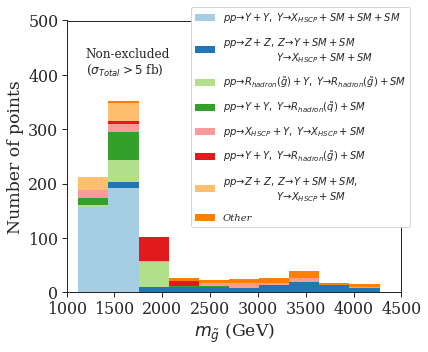

In [21]:
plt.figure(figsize=(6,5))
xvals = [gDF['mass.1000021'] for gDF in groupedMTDF.values()]
nbins = 10
colors = sns.color_palette("Paired")[:len(xvals)]
n, bins, patches = plt.hist(xvals,nbins,stacked=True, 
                            histtype='bar', label=[missToposDict[topo] for topo in groupedMTDF.keys()],
                            linewidth=0,color=colors)
lgd = plt.legend(bbox_to_anchor=(.37, 1.05), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic', 'size': 10},
                 framealpha=1.,labelspacing=1.0)
plt.xlim(1000.,4500.)
plt.ylim(0.,500.)
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.ylabel('Number of points')
# plt.tight_layout()
plt.text(1200,400, 'Non-excluded\n' + r'($\sigma_{Total} > 5$ fb)', fontsize=12)
plt.savefig('Gravitino_missedTopos_nonexcluded.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

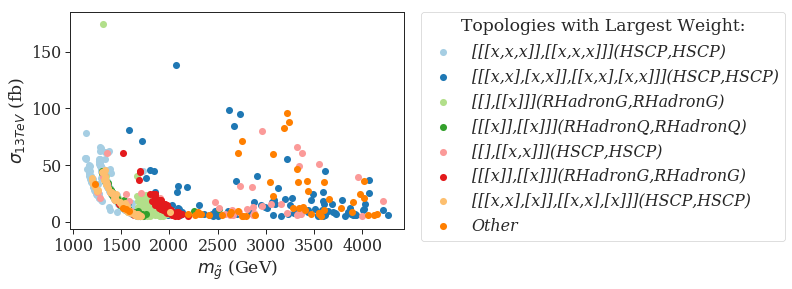

In [22]:
plt.figure()
xvals = [gDF['mass.1000021'] for gDF in groupedMTDF.values()]
yvals = [gDF['totalxsec13TeV(fb)'] for gDF in groupedMTDF.values()]
colors = sns.color_palette("Paired")[:len(xvals)]
for i,x in enumerate(xvals):
    plt.scatter(x,yvals[i],label=list(groupedMTDF.keys())[i],
                            linewidth=0,color=colors[i],s=50)
lgd = plt.legend(fontsize=10,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 prop={'family' :'serif','style' : 'italic'},title='Topologies with Largest Weight:')
# plt.xlim(1000.,4500.)
# plt.ylim(0.,300.)
plt.xlabel(r'$m_{\tilde{g}}$ (GeV)')
plt.ylabel(r'$\sigma_{13TeV}$ (fb)')
# plt.tight_layout()
# plt.text(2100,220, 'Allowed points\n  with missing topologies\n  and '+ r'$\sigma_{13TeV} > 10$ fb', fontsize=12)
plt.savefig('Gravitino_missedTopos_xsec.png',dpi=500, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()